In [22]:
import sys
sys.path.append('../')

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from architectures.LeNet5 import LeNet5, SubSamplingLayer, C3Conv2DLayer
from src.helpers import Device, train
from src.metrics import Accuracy

import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary

%matplotlib inline 

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 1

IMG_SIZE = 32
N_CLASSES = 10

In [4]:
# define transforms
transforms = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor()])

In [5]:
# download and create datasets
train_dataset = datasets.MNIST(root='./mnist_data', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='./mnist_data', 
                               train=False, 
                               transform=transforms)

100.1%

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


113.5%

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw


100.4%

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw


180.4%/Users/rostyslav/anaconda3/envs/pytorch/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-7w1l4mea/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw
Processing...
Done!


In [6]:
# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True,num_workers=5)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=1100*BATCH_SIZE, 
                          shuffle=False,num_workers=5)

In [7]:
batch, y = next(iter(train_loader))
batch.shape

torch.Size([32, 1, 32, 32])

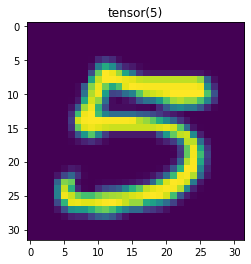

In [12]:
plt.title(y[1])
plt.imshow(batch[1].permute(1, 2, 0))

# Training

In [17]:
torch.manual_seed(RANDOM_SEED)
device = Device().get()
model = LeNet5(N_CLASSES).to(device)

In [31]:
summary(model, tuple(batch[0].shape))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             156
             Atanh-2            [-1, 6, 28, 28]               0
            Conv2d-3            [-1, 6, 14, 14]              12
  SubSamplingLayer-4            [-1, 6, 14, 14]               0
           Sigmoid-5            [-1, 6, 14, 14]               0
            Conv2d-6           [-1, 16, 10, 10]           2,416
     C3Conv2DLayer-7           [-1, 16, 10, 10]               0
             Atanh-8           [-1, 16, 10, 10]               0
            Conv2d-9             [-1, 16, 5, 5]              32
 SubSamplingLayer-10             [-1, 16, 5, 5]               0
           Conv2d-11            [-1, 120, 1, 1]          48,120
            Atanh-12            [-1, 120, 1, 1]               0
           Linear-13                   [-1, 84]          10,164
            Atanh-14                   

In [32]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [33]:
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/LeNet5_MNIST')

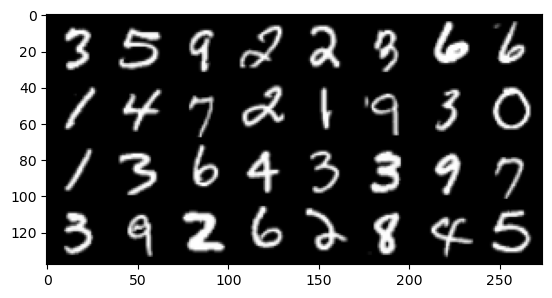

In [51]:
# create grid of images
import torchvision
img_grid = torchvision.utils.make_grid(batch)
writer.add_image('batch_mnist_images', img_grid)
plt.imshow(img_grid.permute(1, 2, 0))

In [52]:
writer.add_graph(model, batch)
writer.close()

15:23:23 --- Epoch: 0	Train loss: 0.0216	Valid loss: 0.0454	Accuracy: 0.9952	Validation Accuracy: 0.9862
15:24:38 --- Epoch: 1	Train loss: 0.0190	Valid loss: 0.0423	Accuracy: 0.9971	Validation Accuracy: 0.9873


../src/helpers.py:87: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


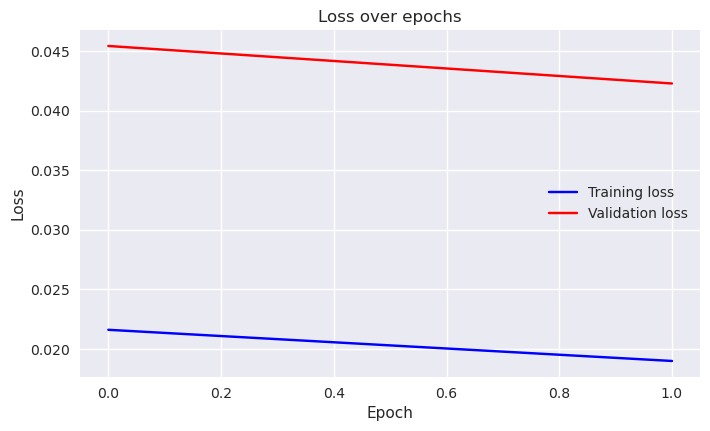

In [56]:
model, optimizer, metrics = train(model, criterion, optimizer, train_loader, valid_loader, 2, device, eval_metrics=[Accuracy()])

../src/helpers.py:44: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  xlabel='Epoch',


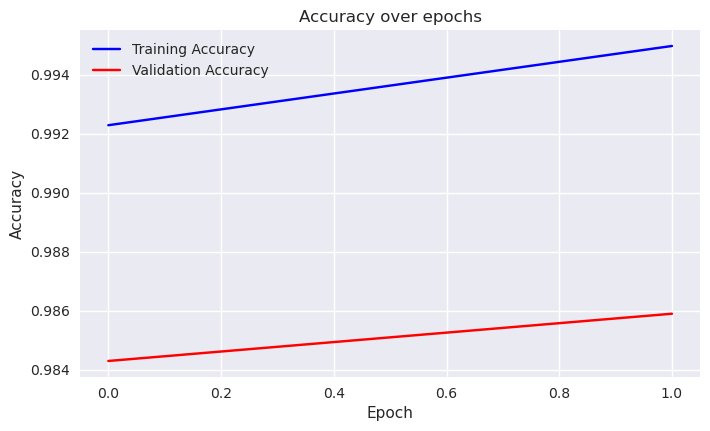

In [45]:
metrics['Accuracy'].plot()